In [8]:
# Data Processing
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import scipy.stats as stats
from scipy.stats import skew

# Data Splitting and Models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier

# Evaluation Metrics
from sklearn.metrics import f1_score, roc_curve, auc, roc_auc_score
import pickle

# Saving Model
from joblib import dump

# Others
#import shap
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE


# Set seaborn defaults and suppress warnings
sns.set()
#warnings.filterwarnings('ignore')

In [3]:
#Lets Load the dataset
df = pd.read_csv("Paitients_Files_Train.csv")
df_ts = pd.read_csv("Paitients_Files_Test.csv")
df_tr = df.copy()

In [4]:
#confirm the dataset has been loaded
df.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,Positive


In [10]:
# Encoding the target variable
df_tr['Sepssis_Encoded'] = df_tr['Sepssis'].map({'Negative': 0, 'Positive': 1})

# Dropping unneeded column
df_tr.drop('ID', axis=1, inplace=True)
df_ts.drop('ID', axis=1, inplace=True)

# Feature Processing & Engineering

### Data Preprocessing

In [5]:
def check_missing_values(data):
    missing_values = data.isna().sum()
    print("Missing values:\n", missing_values)

In [6]:
# Check missing values in train data
check_missing_values(df_tr)

# Check missing values in test data
check_missing_values(df_ts)

Missing values:
 ID           0
PRG          0
PL           0
PR           0
SK           0
TS           0
M11          0
BD2          0
Age          0
Insurance    0
Sepssis      0
dtype: int64
Missing values:
 ID           0
PRG          0
PL           0
PR           0
SK           0
TS           0
M11          0
BD2          0
Age          0
Insurance    0
dtype: int64


#### Checking Imbalance in Target Column

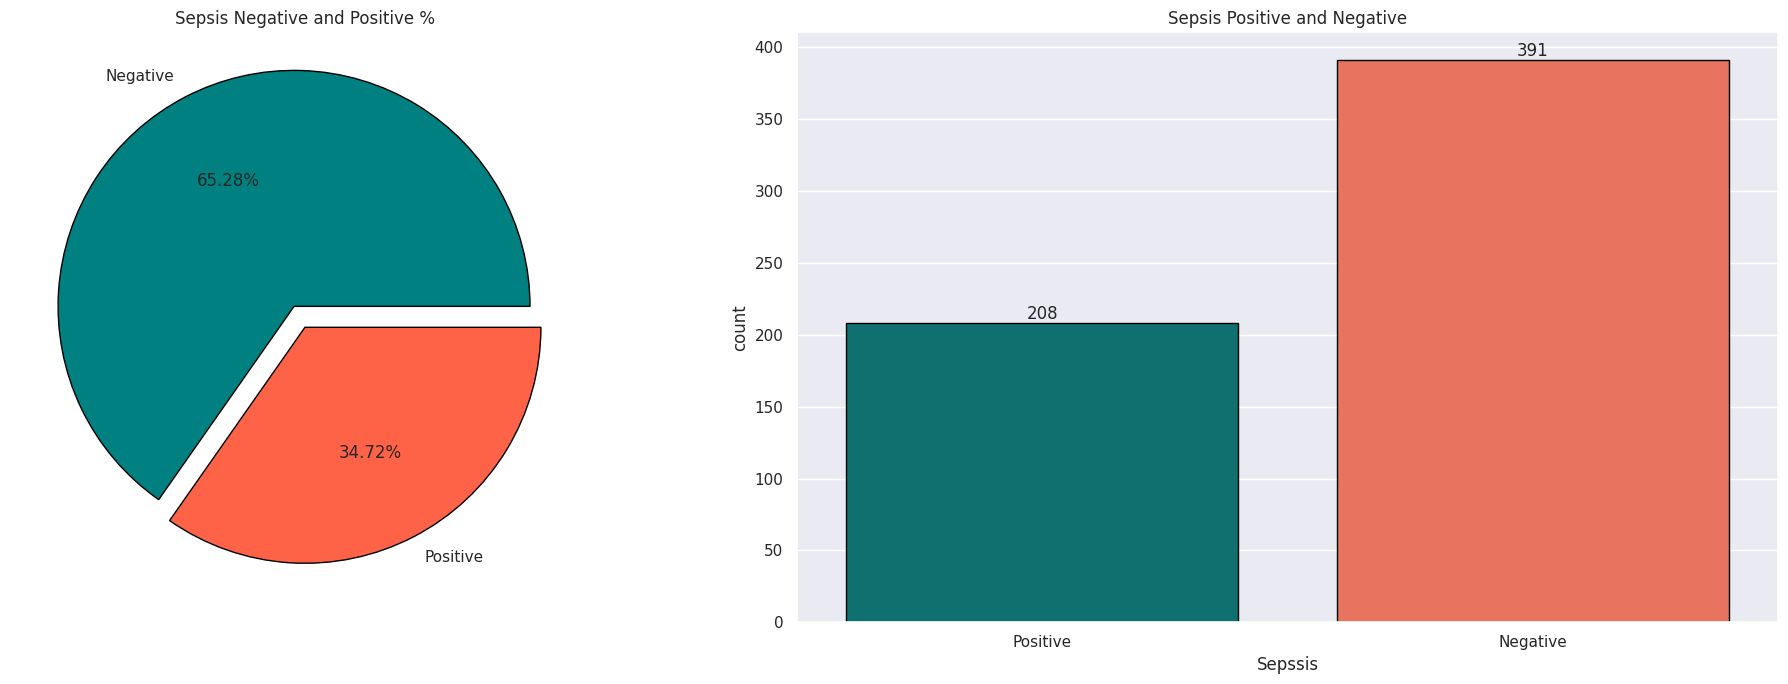

In [12]:
# Define colors for the plots
palette = ['#008080', '#FF6347', '#E50000', '#D2691E']

# Calculate the percentage of positive and negative values
sepsis_counts = df_tr['Sepssis_Encoded'].value_counts()
pie_values = [sepsis_counts[0] / sepsis_counts.sum() * 100, sepsis_counts[1] / sepsis_counts.sum() * 100]

# Create the figure and axes for subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

# Plot the pie chart on the first subplot
axes[0].pie(pie_values, labels=['Negative', 'Positive'], autopct='%1.2f%%', explode=(0.1, 0),
            colors=palette[:2], wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True})
axes[0].set_title('Sepsis Negative and Positive %')

# Plot the countplot on the second subplot
sns.countplot(data=df_tr, x='Sepssis', palette=palette[:2], edgecolor='black', ax=axes[1])
axes[1].set_xticklabels(['Positive', 'Negative'])
axes[1].set_title('Sepsis Positive and Negative')

# Add labels to the countplot bars
for container in axes[1].containers:
    axes[1].bar_label(container)

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

- Sepsis column is not balance as shown in the diagram above, where positive sepsis is 208 that is 34.72% and negative is 391 which is 66.28%

In [13]:
df.drop('ID', axis = 1, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PRG        599 non-null    int64  
 1   PL         599 non-null    int64  
 2   PR         599 non-null    int64  
 3   SK         599 non-null    int64  
 4   TS         599 non-null    int64  
 5   M11        599 non-null    float64
 6   BD2        599 non-null    float64
 7   Age        599 non-null    int64  
 8   Insurance  599 non-null    int64  
 9   Sepssis    599 non-null    object 
dtypes: float64(2), int64(7), object(1)
memory usage: 46.9+ KB


#### TARGET ENCODING

In [14]:
label_encoder = LabelEncoder()
encoded_target = label_encoder.fit_transform(df['Sepssis'])
target_encoded = pd.DataFrame(encoded_target, columns=['Sepssis'])

In [15]:
train_encoded = pd.concat([df.iloc[:, :-1], target_encoded], axis=1)
train_encoded.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,6,148,72,35,0,33.6,0.627,50,0,1
1,1,85,66,29,0,26.6,0.351,31,0,0
2,8,183,64,0,0,23.3,0.672,32,1,1
3,1,89,66,23,94,28.1,0.167,21,1,0
4,0,137,40,35,168,43.1,2.288,33,1,1


#### DATA SPLITING

In [16]:
# split train+validation set into training and validation sets
X_train, X_eval, y_train, y_eval = train_test_split(train_encoded.iloc[:, :-1], train_encoded.iloc[:, -1:], test_size=0.2, random_state=42, stratify=train_encoded.iloc[:, -1:])

# Print the shapes of the train and validation sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_eval shape:", X_eval.shape)
print("y_eval shape:", y_eval.shape)

X_train shape: (479, 9)
y_train shape: (479, 1)
X_eval shape: (120, 9)
y_eval shape: (120, 1)


#### IMPUTATION

In [17]:
# Creating imputer variables
numerical_imputer = SimpleImputer(strategy = "mean")
X_train_imputer = numerical_imputer.fit_transform(X_train)
X_eval_imputer = numerical_imputer.transform(X_eval)
test_impurter = numerical_imputer.transform(df_ts)

#### SCALING

In [18]:
scaler = StandardScaler()
X_train_df = scaler.fit_transform(X_train_imputer)
X_eval_df = scaler.fit_transform(X_eval_imputer)
test_df = scaler.fit_transform(test_impurter)

In [19]:
#X_train_df, y_train, X_eval_df, y_eval



#### CUSTOM ML FUNCTIONS

In [20]:
# Confusion Matrix Function
def plot_metric(confusion, name):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
    confusion.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
    confusion.flatten()/np.sum(confusion)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
    zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax = sns.heatmap(confusion, annot=labels, fmt='', cmap='viridis')
    ax.set_title(f'{name}\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    ## Display the visualization of the Confusion Matrix.
    plt.show()

In [21]:
# Function for Training Models

def train_ml_model(X_train, y_train, X_eval, y_eval, model_class, **model_params):
    """
    Train a machine learning model, calculate various metrics, generate an ROC curve,
    and return results in a DataFrame.

    Parameters:
    - X_train: Training features
    - y_train: Training labels
    - X_eval: Evaluation features
    - y_eval: Evaluation labels
    - model_class: Class of the machine learning model to be used (e.g., LogisticRegression)
    - **model_params: Additional parameters for the model constructor

    Returns:
    - result_df: DataFrame containing model, predictions, F1-score, FPR, TPR, thresholds, and AUC-score
    """

    results = []  # List to store results for each model

    # Initialize the model
    model = model_class(**model_params)
    model.fit(X_train, y_train)

    # Make predictions on the evaluation set
    predictions = model.predict(X_eval)

    # Calculate F1 score
    f1 = round(f1_score(y_eval, predictions), 2)

    # Make predictions on the training and evaluation sets
    train_preds = model.predict(X_train)
    eval_preds = model.predict(X_eval)

    # Calculate F1-score for training and evaluation sets
    train_f1 = f1_score(y_train, train_preds)
    eval_f1 = f1_score(y_eval, eval_preds)

    # Determine if the model is overfitting, underfitting, or balanced
    if train_f1 > eval_f1:
        assessment = "Overfitting"
    elif train_f1 < eval_f1:
        assessment = "Underfitting"
    else:
        assessment = "Balanced"

    # Calculate and Plot confusion matrix
    confusion = confusion_matrix(y_eval, predictions)
    plot_metric(confusion, model_class())

    # Calculate false positive rate, true positive rate, and thresholds using roc_curve
    fpr, tpr, thresholds = roc_curve(y_eval, predictions)

    # Calculate AUC score
    auc = round(roc_auc_score(y_eval, predictions), 2)

    # Create ROC curve plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

    # Create a DataFrame to store the results
    result_data = {
        'Model': model_class.__name__,  # Using the model class name as the identifier,
        #'Predictions': [predictions],
        'F1-Score': f1,
        #'FPR': [fpr],
        #'TPR': [tpr],
        #'Thresholds': [thresholds],
        'AUC-Score': auc,
        'Assessment': assessment
    }

    results.append(result_data)

    result_df = pd.DataFrame(results)

    return result_df

### Training ML Model with Unbalanced Dataset

#### Model 1

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


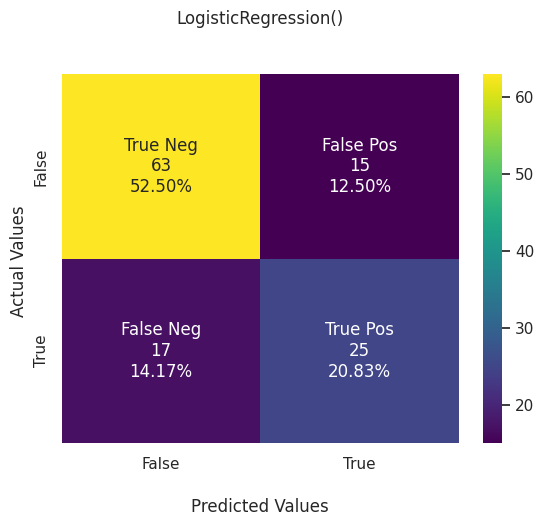

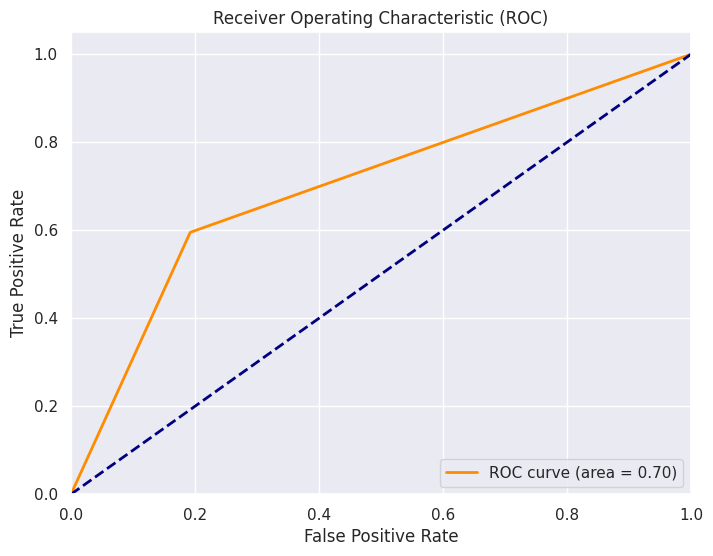

,Model,F1-Score,AUC-Score,Assessment
0,LogisticRegression,0.61,0.7,Overfitting


In [22]:
result_df = train_ml_model(X_train_df, y_train, X_eval_df, y_eval, LogisticRegression, random_state=42)
lr = result_df
lr

#### Model 2

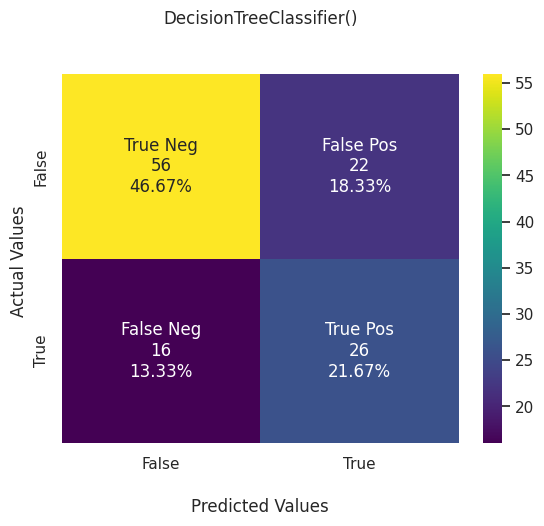

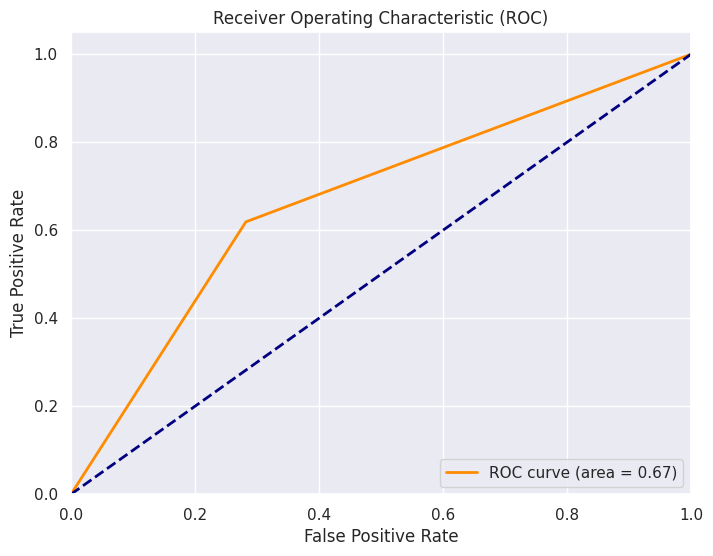

,Model,F1-Score,AUC-Score,Assessment
0,DecisionTreeClassifier,0.58,0.67,Overfitting


In [23]:
result_df = train_ml_model(X_train_df, y_train, X_eval_df, y_eval, DecisionTreeClassifier, random_state=42)
dt = result_df
dt

#### Model 3

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


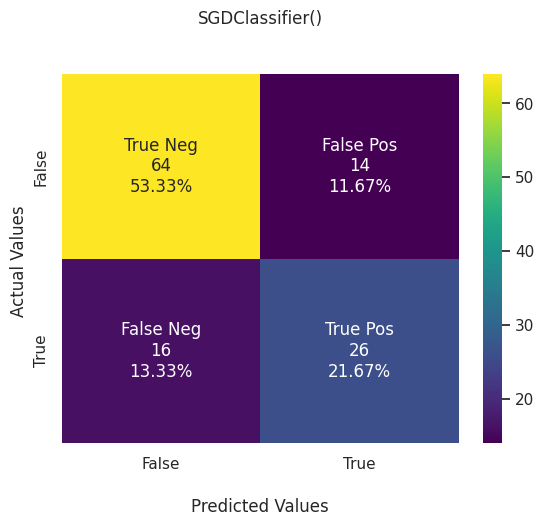

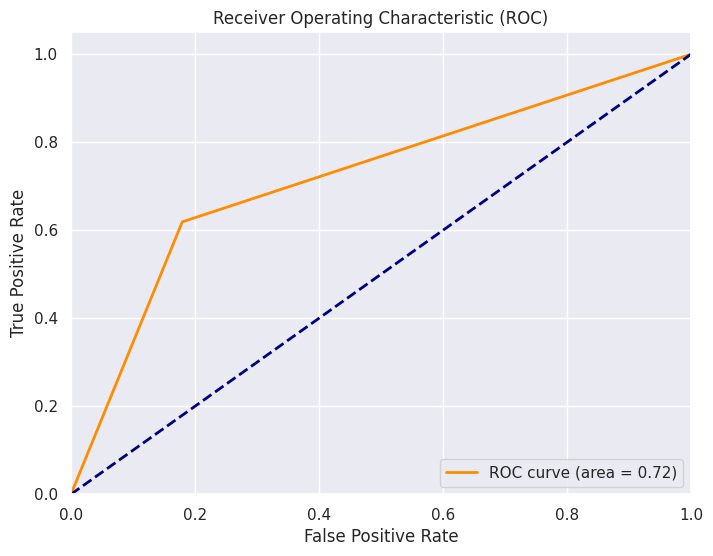

,Model,F1-Score,AUC-Score,Assessment
0,SGDClassifier,0.63,0.72,Underfitting


In [24]:
result_df = train_ml_model(X_train_df, y_train, X_eval_df, y_eval, SGDClassifier, random_state=42)
sgd = result_df
sgd

In [25]:
#lgb_model = LGBMClassifier(random_state=42)
#result_df = train_ml_model(X_train_df, y_train, X_eval_df, y_eval, lgb_model)

#### Model 4

<ipython-input-21-27e5040e8f7b>:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


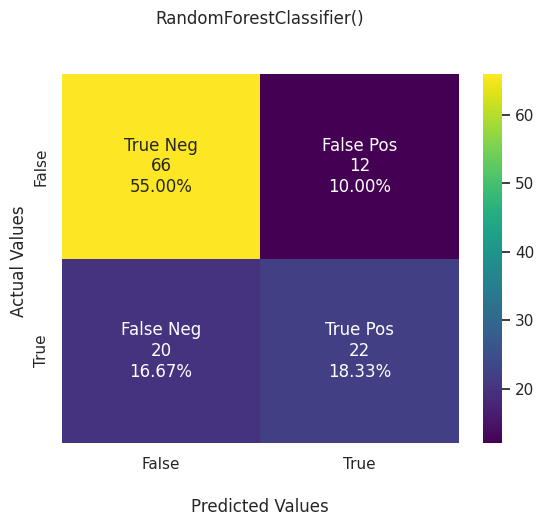

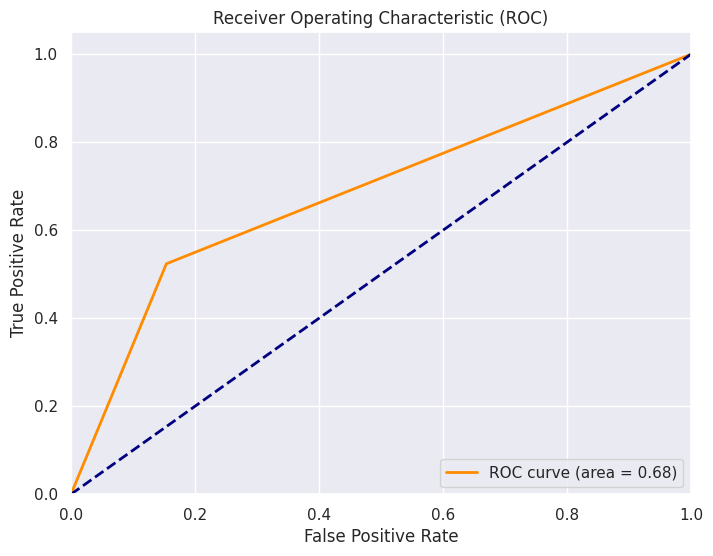

,Model,F1-Score,AUC-Score,Assessment
0,RandomForestClassifier,0.58,0.68,Overfitting


In [26]:
#rf_model = RandomForestClassifier(random_state=42)
result_df = train_ml_model(X_train_df, y_train, X_eval_df, y_eval, RandomForestClassifier, random_state=42)
rf = result_df
rf

#### Model 5

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


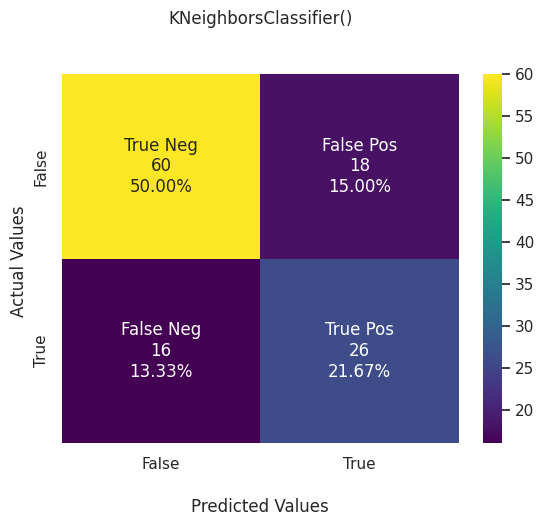

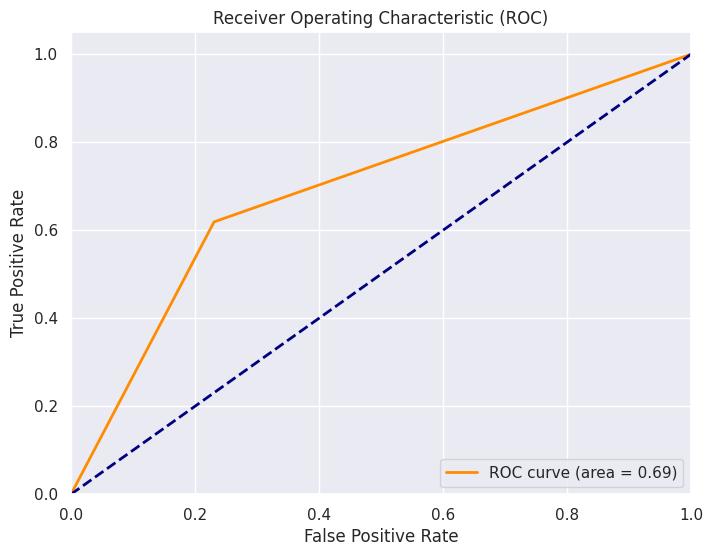

,Model,F1-Score,AUC-Score,Assessment
0,KNeighborsClassifier,0.6,0.69,Overfitting


In [27]:
result_df = train_ml_model(X_train_df, y_train, X_eval_df, y_eval, KNeighborsClassifier)
knn = result_df
knn

#### Model 6

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


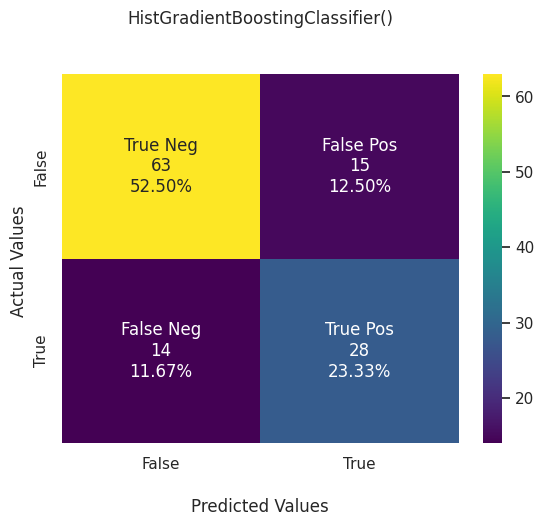

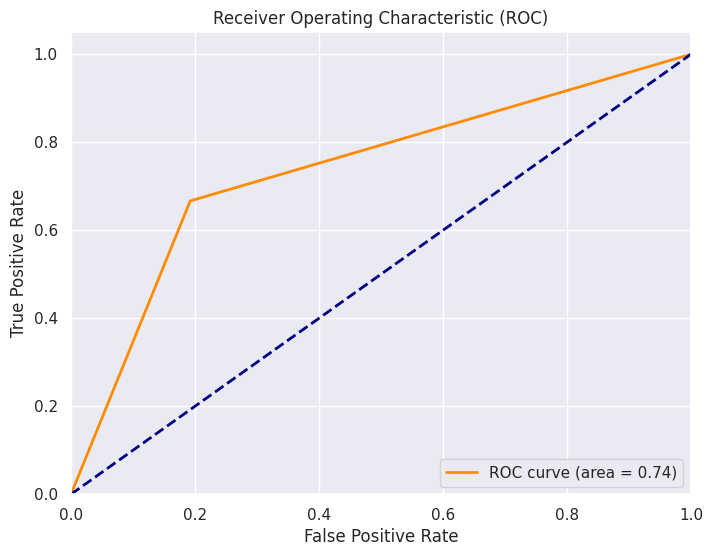

,Model,F1-Score,AUC-Score,Assessment
0,HistGradientBoostingClassifier,0.66,0.74,Overfitting


In [28]:
result_df = train_ml_model(X_train_df, y_train, X_eval_df, y_eval, HistGradientBoostingClassifier, random_state=42)
hgb = result_df
hgb

#### Model 7

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


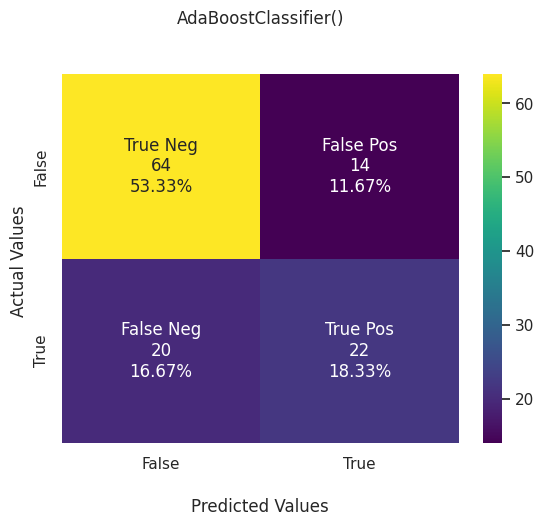

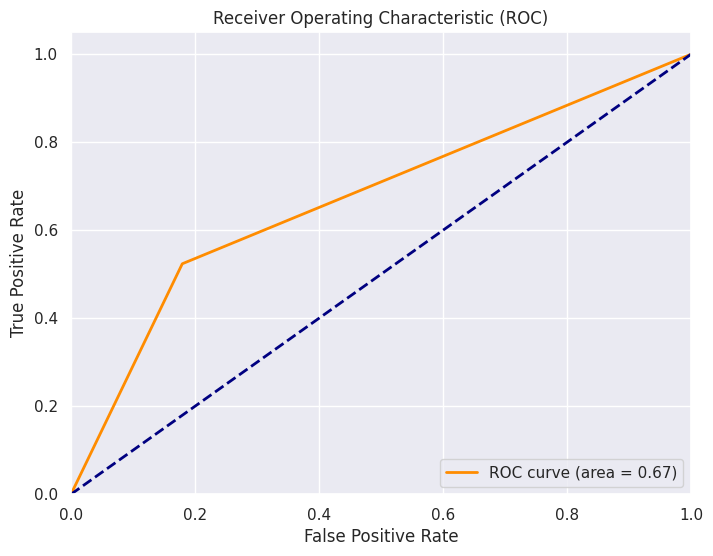

,Model,F1-Score,AUC-Score,Assessment
0,AdaBoostClassifier,0.56,0.67,Overfitting


In [29]:
result_df = train_ml_model(X_train_df, y_train, X_eval_df, y_eval, AdaBoostClassifier, random_state=42)
adb = result_df
adb

### Models Comparison For UnBalanced Dataset

In [30]:
results= {'model':['Decision Tree','Random Forest','AdaBoost','Logistic Regression','KNeighbors','HistGradientBoosting','SGBoost'],
         'f1_score':[dt['F1-Score'].iloc[0],rf['F1-Score'].iloc[0],lr['F1-Score'].iloc[0],knn['F1-Score'].iloc[0],hgb['F1-Score'].iloc[0],
                    sgd['F1-Score'].iloc[0], adb['F1-Score'].iloc[0]],
         'AUC_score':[dt['AUC-Score'].iloc[0],rf['AUC-Score'].iloc[0],lr['AUC-Score'].iloc[0],knn['AUC-Score'].iloc[0],hgb['AUC-Score'].iloc[0],
                    sgd['AUC-Score'].iloc[0], adb['AUC-Score'].iloc[0]],
         'Assessment':[dt['Assessment'].iloc[0],rf['Assessment'].iloc[0],lr['Assessment'].iloc[0],knn['Assessment'].iloc[0],hgb['Assessment'].iloc[0],
                    sgd['Assessment'].iloc[0], adb['Assessment'].iloc[0]]
}

results_df= pd.DataFrame(results)
results_df = results_df.sort_values(by ='AUC_score', ascending =False)
results_df

,model,f1_score,AUC_score,Assessment
4,KNeighbors,0.66,0.74,Overfitting
5,HistGradientBoosting,0.63,0.72,Underfitting
2,AdaBoost,0.61,0.70,Overfitting
3,Logistic Regression,0.60,0.69,Overfitting
1,Random Forest,0.58,0.68,Overfitting
0,Decision Tree,0.58,0.67,Overfitting
6,SGBoost,0.56,0.67,Overfitting


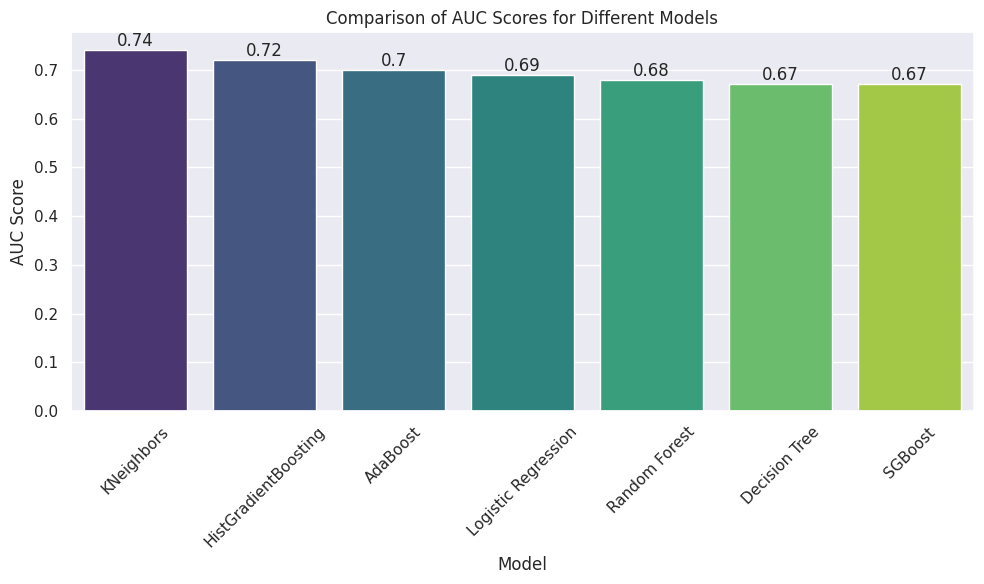

In [31]:
# Create the bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='model', y='AUC_score', palette='viridis')

# Add data labels
for i, value in enumerate(results_df['AUC_score']):
    plt.text(i, value, round(value, 2), ha='center', va='bottom')

# Set other plot properties
plt.xticks(rotation=45)
plt.xlabel('Model')
plt.ylabel('AUC Score')
plt.title('Comparison of AUC Scores for Different Models')
plt.tight_layout()
plt.show()

### Training of ML Models with balanced dataset

### Balancing Traning Dataset

In [32]:
# Use Over-sampling/Under-sampling methods, more details here: https://imbalanced-learn.org/stable/install.html
oversample= SMOTE()
X_train_resampled,y_train_resampled= oversample.fit_resample(X_train_df, y_train)
X_train_resampled.shape,y_train_resampled.shape

((626, 9), (626, 1))

#### Balanced Model 1

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


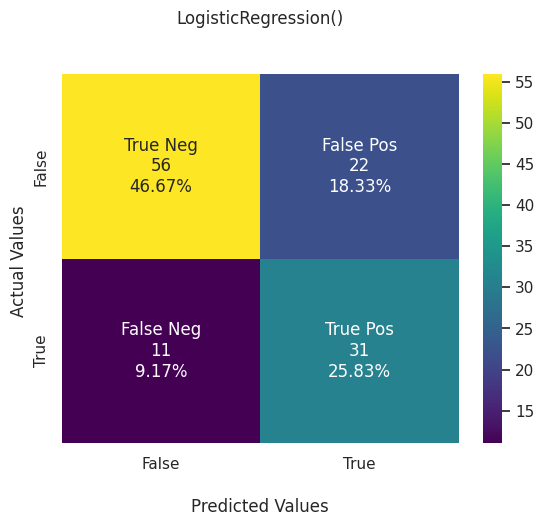

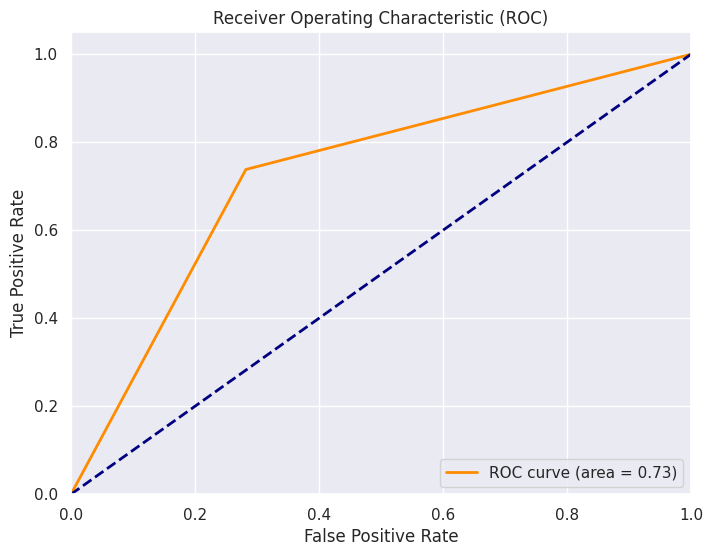

,Model,F1-Score,AUC-Score,Assessment
0,LogisticRegression,0.65,0.73,Overfitting


In [33]:
result_df = train_ml_model(X_train_resampled,y_train_resampled, X_eval_df, y_eval, LogisticRegression, random_state=42)
lr_RE = result_df
lr_RE

#### Balanced Model 2

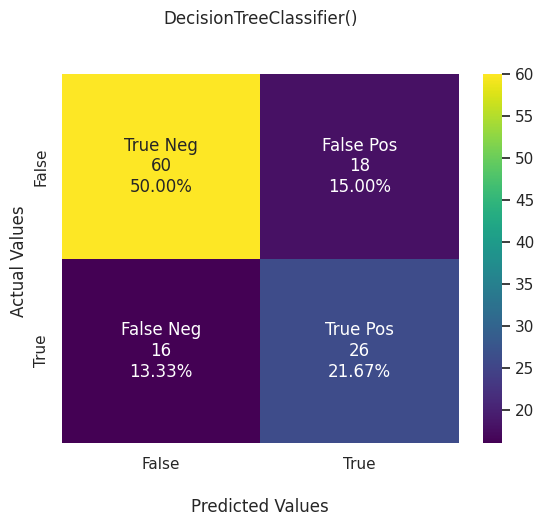

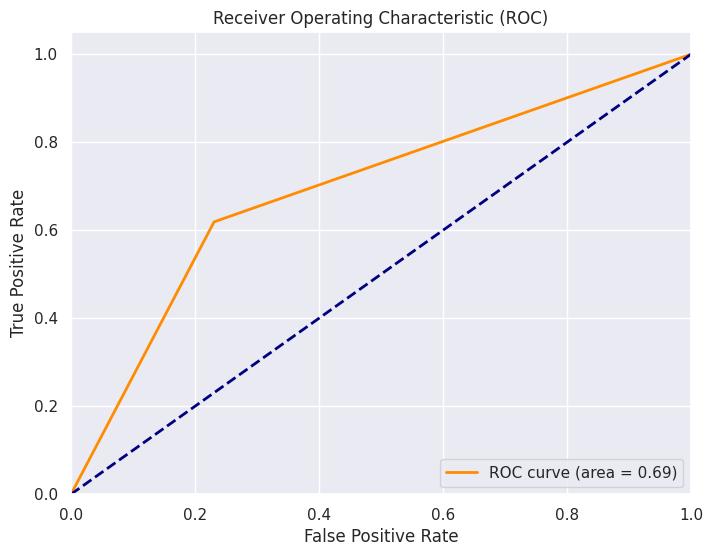

,Model,F1-Score,AUC-Score,Assessment
0,DecisionTreeClassifier,0.6,0.69,Overfitting


In [34]:
result_df = train_ml_model(X_train_resampled,y_train_resampled, X_eval_df, y_eval, DecisionTreeClassifier, random_state=42)
dt_RE = result_df
dt_RE

#### Balanced Model 3

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


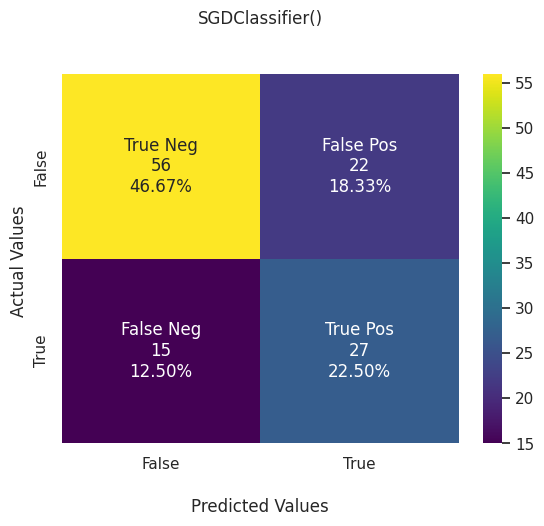

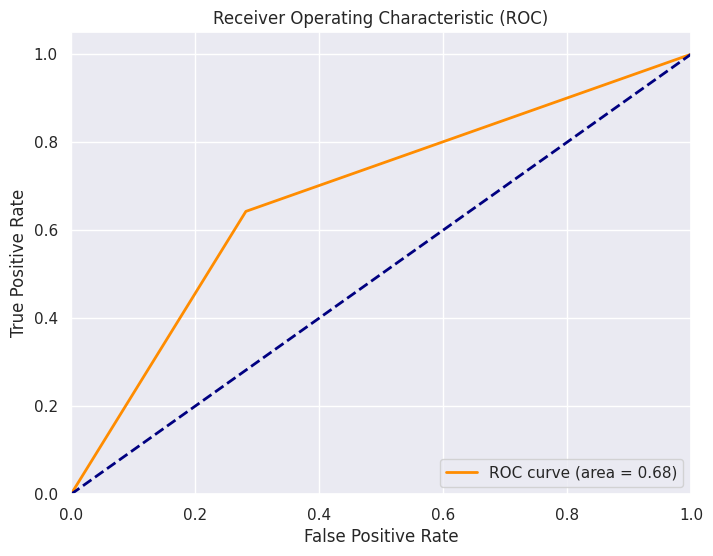

,Model,F1-Score,AUC-Score,Assessment
0,SGDClassifier,0.59,0.68,Overfitting


In [35]:
result_df = train_ml_model(X_train_resampled,y_train_resampled, X_eval_df, y_eval, SGDClassifier, random_state=42)
sgd_RE = result_df
sgd_RE

#### Balanced Model 4

<ipython-input-21-27e5040e8f7b>:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


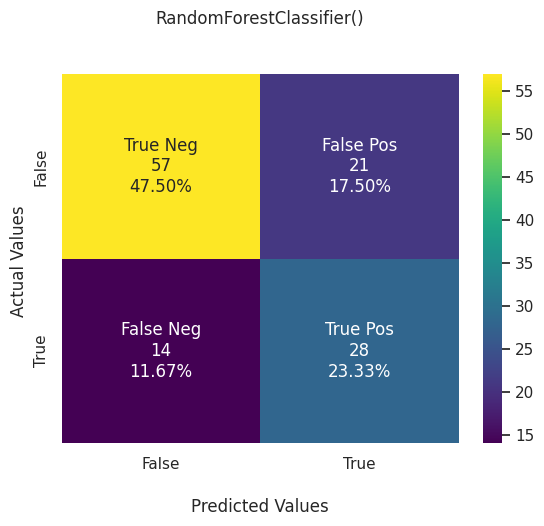

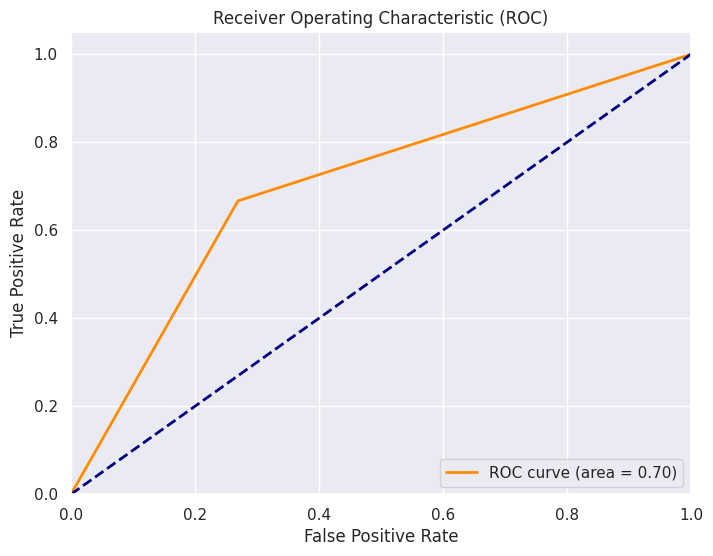

,Model,F1-Score,AUC-Score,Assessment
0,RandomForestClassifier,0.62,0.7,Overfitting


In [36]:
result_df = train_ml_model(X_train_resampled,y_train_resampled, X_eval_df, y_eval, RandomForestClassifier, random_state=42)
rf_RE = result_df
rf_RE

#### Balanced Model 5

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


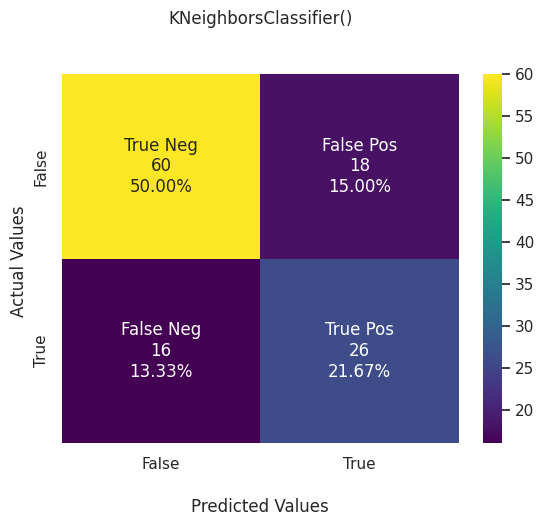

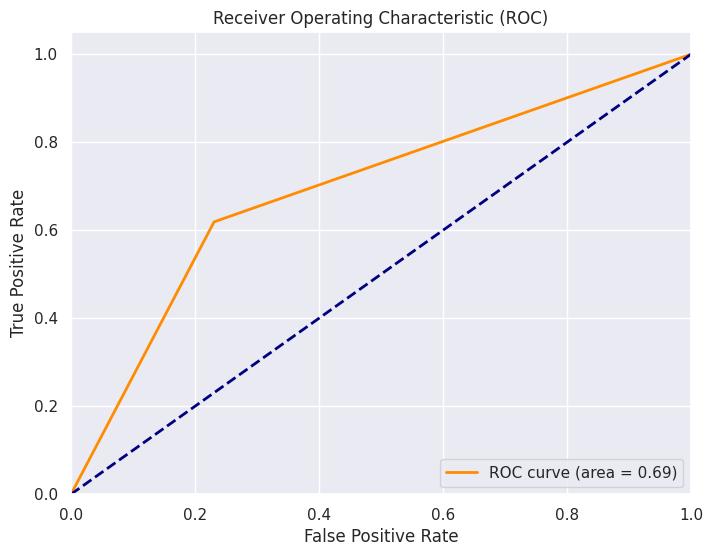

,Model,F1-Score,AUC-Score,Assessment
0,KNeighborsClassifier,0.6,0.69,Overfitting


In [37]:
result_df = train_ml_model(X_train_df, y_train, X_eval_df, y_eval, KNeighborsClassifier)
knn_RE = result_df
knn_RE

#### Balanced Model 6

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


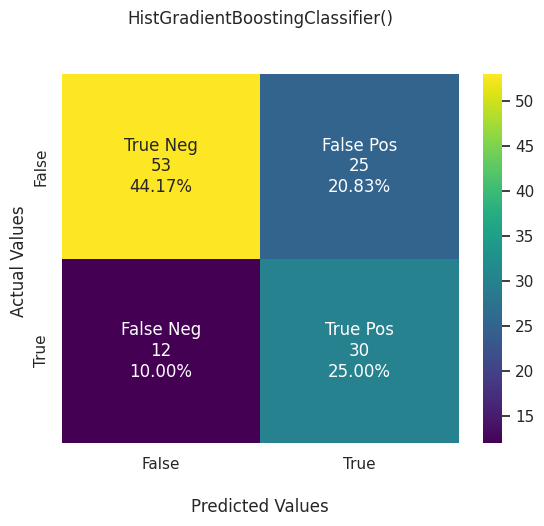

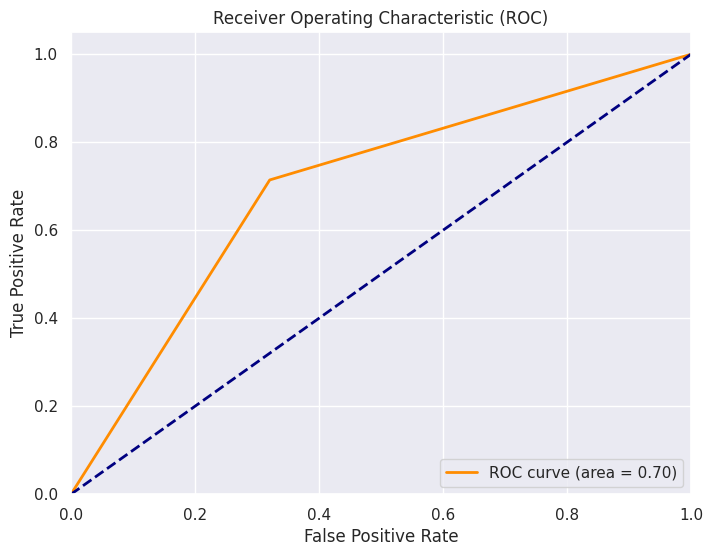

,Model,F1-Score,AUC-Score,Assessment
0,HistGradientBoostingClassifier,0.62,0.7,Overfitting


In [38]:
result_df = train_ml_model(X_train_resampled,y_train_resampled, X_eval_df, y_eval, HistGradientBoostingClassifier, random_state=42)
hgb_RE = result_df
hgb_RE

#### Balanced Model 7

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


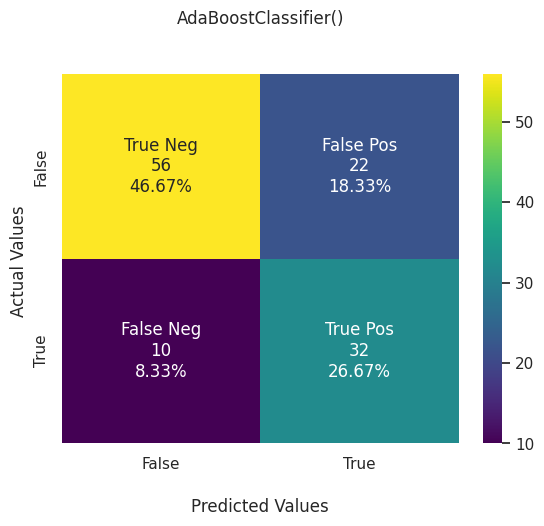

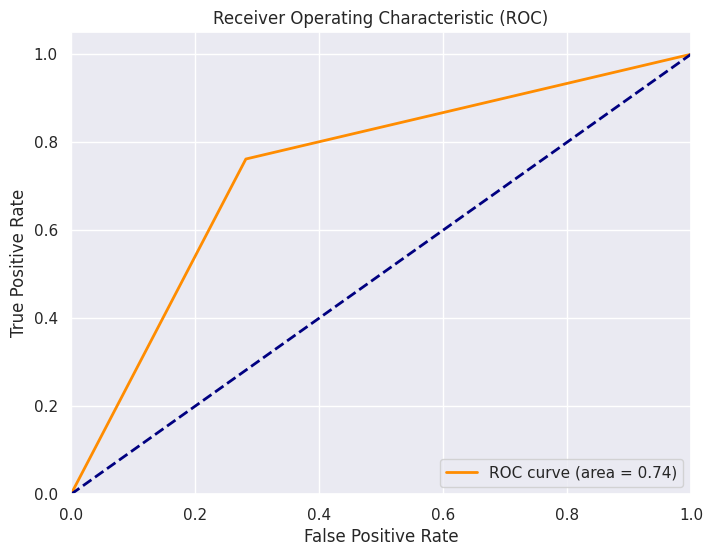

,Model,F1-Score,AUC-Score,Assessment
0,AdaBoostClassifier,0.67,0.74,Overfitting


In [39]:
result_df = train_ml_model(X_train_resampled,y_train_resampled, X_eval_df, y_eval, AdaBoostClassifier, random_state=42)
adb_RE = result_df
adb_RE

### Models comparison For Balanced Dataset

In [40]:
balanced_results= {'model':['Decision Tree','Random Forest','AdaBoost','Logistic Regression','KNeighbors','HistGradientBoosting','SGBoost'],
         'f1_score':[dt_RE['F1-Score'].iloc[0],rf_RE['F1-Score'].iloc[0],lr_RE['F1-Score'].iloc[0],knn_RE['F1-Score'].iloc[0],hgb_RE['F1-Score'].iloc[0],
                    sgd_RE['F1-Score'].iloc[0], adb_RE['F1-Score'].iloc[0]],
         'AUC_score':[dt_RE['AUC-Score'].iloc[0],rf_RE['AUC-Score'].iloc[0],lr_RE['AUC-Score'].iloc[0],knn_RE['AUC-Score'].iloc[0],hgb_RE['AUC-Score'].iloc[0],
                    sgd['AUC-Score'].iloc[0], adb_RE['AUC-Score'].iloc[0]],
         'Assessment':[dt_RE['Assessment'].iloc[0],rf_RE['Assessment'].iloc[0],lr_RE['Assessment'].iloc[0],knn_RE['Assessment'].iloc[0],hgb_RE['Assessment'].iloc[0],
                    sgd_RE['Assessment'].iloc[0], adb_RE['Assessment'].iloc[0]]
}

balanced_results_df= pd.DataFrame(results)
balanced_results_df = results_df.sort_values(by ='AUC_score', ascending =False)
balanced_results_df

,model,f1_score,AUC_score,Assessment
4,KNeighbors,0.66,0.74,Overfitting
5,HistGradientBoosting,0.63,0.72,Underfitting
2,AdaBoost,0.61,0.70,Overfitting
3,Logistic Regression,0.60,0.69,Overfitting
1,Random Forest,0.58,0.68,Overfitting
0,Decision Tree,0.58,0.67,Overfitting
6,SGBoost,0.56,0.67,Overfitting


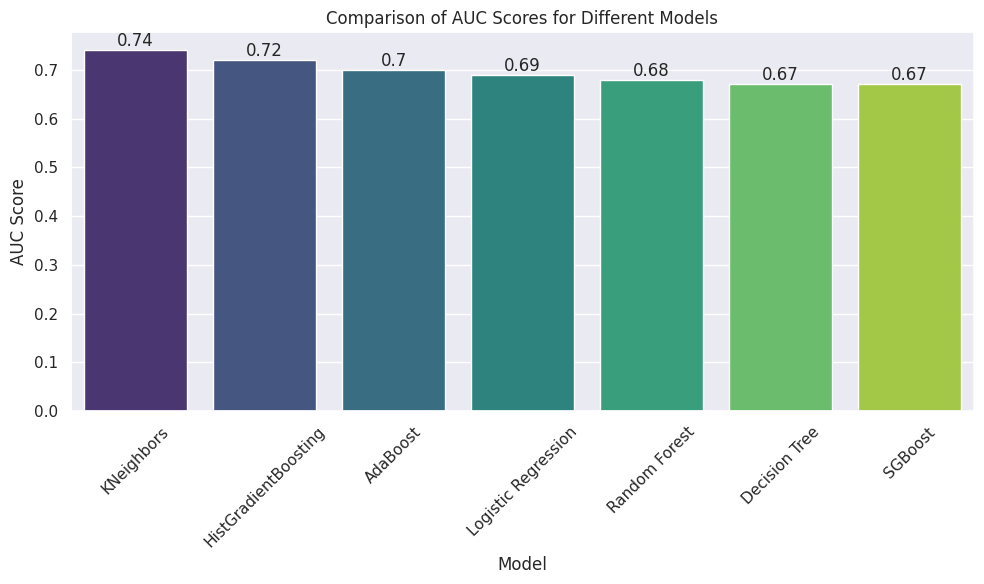

In [41]:
# Create the bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=balanced_results_df, x='model', y='AUC_score', palette='viridis')

# Add data labels
for i, value in enumerate(balanced_results_df['AUC_score']):
    plt.text(i, value, round(value, 2), ha='center', va='bottom')

# Set other plot properties
plt.xticks(rotation=45)
plt.xlabel('Model')
plt.ylabel('AUC Score')
plt.title('Comparison of AUC Scores for Different Models')
plt.tight_layout()
plt.show()